<a href="https://colab.research.google.com/github/sumitmukherjee7/express/blob/master/notebooks/high_level_circuit_finding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer-Specific Interpretability: Mechanistic Interpretability
**Michael Hanna**

This notebook will explain how to use a pre-built set of tools for playing with models' computational graphs in order to find and verify circuits! We will focus on the greater-than task, but you can use this code to find your own circuits of interest as well.

---
⚠️**Before starting this notebook:**⚠️
- [ ] Change the runtime to GPU (`Runtime -> Change runtime type -> Hardware Accelator -> GPU`).

## 0 Setup
Just run this code -- don't bother reading it.

In [1]:
%pip install transformer-lens
!apt install -y graphviz
!apt install libgraphviz-dev
%pip install pygraphviz
%pip install cmapy
!wget https://raw.githubusercontent.com/hannamw/eacl-tutorial-resources/main/files/greater-than-data.csv
!git clone https://github.com/hannamw/EAP-positional.git
%cd EAP-positional
!git checkout tutorial
%pip install -e .
import sys, os
sys.path.append(os.getcwd())
%cd ..

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 req

In [2]:
# Import stuff
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from typing import List, Union, Optional, Tuple, Literal
from functools import partial
from IPython.display import Image, display

import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, ActivationCache
import plotly.io as pio

pio.renderers.default = "colab"

device = "cuda" if torch.cuda.is_available() else "cpu"
if not torch.cuda.is_available():
    print("WARNING: Running on CPU. Did you remember to set your Colab accelerator to GPU?")

## 1 Loading and Running Models

This tutorial is built with TransformerLens, a powerful interpretability library for working with pre-trained transformer-based NLP models. TransformerLens allows you to easily interact with model representations and components at a low-level. TransformerLens is implemented in PyTorch, so models should feel similar to those you have used before. So far, it supports primarily autoregressive models (e.g., GPT-2). Models must be ported to TransformerLens before use.

To begin, we will simply load and run a pre-trained model, `gpt2-small`. By setting `model_name` to other values, you can load other models. See other valid model names [here](https://neelnanda-io.github.io/TransformerLens/model_properties_table.html).

In [3]:
model_name = 'gpt2-small'
model = HookedTransformer.from_pretrained(model_name, device=device)
model.cfg.use_attn_in = True
model.cfg.use_split_qkv_input = True
model.cfg.use_attn_result = True
model.cfg.use_hook_mlp_in = True

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer


Models in TransformerLens run very similarly to HuggingFace Transformers models. Unlike HuggingFace models, however, TransformerLens' HookedTransformers bundle together models and tokenizers. You can access the tokenizer via `model.tokenizer`, but you can also call `model()` directly on strings (or on tokens), as seen below.

In [4]:
s = "This year's EACL takes place in St. Julian's, on the beautiful Mediterranean island of"
logits = model(s).squeeze(0).cpu()
probs = torch.softmax(logits, dim=-1)

# let's see what the top 5 predictions are
probs, next_tokens = torch.topk(probs[-1], 5)
print(s, "...")
for token_id, prob in zip(next_tokens, probs):
    token = model.tokenizer.decode(token_id.item())
    print(f"{token.strip()}\t {prob.item():.3f}")

This year's EACL takes place in St. Julian's, on the beautiful Mediterranean island of ...
Sard	 0.078
St	 0.058
Sicily	 0.058
Les	 0.054
L	 0.037


## 2 The Task: Greater-Than

Now that we've loaded up a model, let's look for a circuit for a specific task! In this tutorial, we'll focus on the greater-than task, which has a known and faithful circuit, but you can replace this with your own as well!

### 2.1 Loading and viewing the data
For your convenience, we've prepared a pre-made dataset for this task. Each datapoint is a clean sentence, corrupted sentence, and the start year of the event; the corrupted start year is always `01`.

In this dataset, all sentences tokenize to the same length! It's only necessary that each pair of (clean, corrupted) tokenize to the same length, but if all sentences are the same length, you can always assess your metric on the final (-1) token position, instead of taking into account input lengths.

In [5]:
df = pd.read_csv('greater-than-data.csv')
print(df.iloc[0])

clean         The effect lasted from the year 1282 to the ye...
corrupted     The effect lasted from the year 1201 to the ye...
start_year                                                   82
Name: 0, dtype: object


We'll also batch this dataset for convenience.

In [6]:
def batch_dataset(df, batch_size=8):
    clean, corrupted, label = [df[col].tolist() for col in ['clean', 'corrupted', 'start_year']]
    clean = [clean[i:i+batch_size] for i in range(0, len(df), batch_size)]
    corrupted = [corrupted[i:i+batch_size] for i in range(0, len(df), batch_size)]
    label = [torch.tensor(label[i:i+batch_size]) for i in range(0, len(df), batch_size)]
    return [(clean[i], corrupted[i], label[i]) for i in range(len(clean))]

dataset = batch_dataset(df, batch_size=8)

One important note: for this procedure to work, the lengths of the clean and corrupted inputs ("The war lasted from the 1741 to the year 17" and "The war lasted from the 1701 to the year 17") must be identical post-tokenization! Otherwise, you can't directly patch one sequence's activations onto another, because their sizes won't match! We test this here.

In [7]:
for clean, corrupted, _ in dataset:
    clean_toks = model.tokenizer(clean).input_ids
    corrupted_toks = model.tokenizer(corrupted).input_ids
    for clean_example_toks, corrupted_example_toks in zip(clean_toks, corrupted_toks):
        assert len(clean_example_toks) == len(corrupted_example_toks), f"Found clean/corrupted pair with different tokenized lengths: '{clean_example_toks}' and '{corrupted_example_toks}' with lengths {len(clean_example_toks)} and {len(corrupted_example_toks)}"

### 2.2 The Metric
We will measure performance using probability difference (`prob_diff`). This measures the probability assigned to correct years minus the probability assigned to incorrect year. So, for a sentence like "The journey lasted from the year 1577 to the year 15", we would measure the probability assigned to years > 77, minus the probability assigned to years <= 77.

In [8]:
year_indices = torch.tensor([model.tokenizer(f'{year:02d}').input_ids[0] for year in range(100)])

def prob_diff(logits: torch.Tensor, corrupted_logits, input_lengths,  labels: torch.Tensor, loss=False, mean=False):
    """
    the probability difference metric, which takes in logits and labels (years), and
    returns the difference in prob. assigned to valid (> year) and invalid (<= year) tokens

    (corrupted_logits and input_lengths are due to the Graph framework introduced below)
    """
    probs = torch.softmax(logits[:, -1], dim=-1)
    probs = probs[:, year_indices]

    results = []
    for prob, year in zip(probs, labels):
        results.append(prob[year + 1 :].sum() - prob[: year + 1].sum())

    results = torch.stack(results)
    if loss:
        results = -results
    if mean:
        results = results.mean()
    return results

metric = prob_diff

## 3 Working with Circuits

In this section, we'll work with `Graph`s, objects that makes circuit finding and evaluation easy. A `Graph` represents a model's computational graph. Once instantiated, it contains various `Node`s, representing mostly attention heads and MLPs, and `Edge`s representing connections between nodes. Each `Node` and `Edge` is either in the graph (circuit) or not; by default, all `Node` and `Edge` objects are included within the graph.

Let's start by instantiating a `Graph`.

In [9]:
import eap
from eap.graph import Graph
from eap import evaluate
from eap import attribute_mem as attribute

In [10]:
g = Graph.from_model(model)
print(list(g.nodes.items())[:10])
print(list(g.edges.items())[:10])

[('input', Node(input)), ('a0.h0', Node(a0.h0)), ('a0.h1', Node(a0.h1)), ('a0.h2', Node(a0.h2)), ('a0.h3', Node(a0.h3)), ('a0.h4', Node(a0.h4)), ('a0.h5', Node(a0.h5)), ('a0.h6', Node(a0.h6)), ('a0.h7', Node(a0.h7)), ('a0.h8', Node(a0.h8))]
[('input->a0.h0<q>', Edge(input->a0.h0<q>)), ('input->a0.h0<k>', Edge(input->a0.h0<k>)), ('input->a0.h0<v>', Edge(input->a0.h0<v>)), ('input->a0.h1<q>', Edge(input->a0.h1<q>)), ('input->a0.h1<k>', Edge(input->a0.h1<k>)), ('input->a0.h1<v>', Edge(input->a0.h1<v>)), ('input->a0.h2<q>', Edge(input->a0.h2<q>)), ('input->a0.h2<k>', Edge(input->a0.h2<k>)), ('input->a0.h2<v>', Edge(input->a0.h2<v>)), ('input->a0.h3<q>', Edge(input->a0.h3<q>))]


### 3.1 What should go in our Circuit?
Right now everything is in our circuit, but we'd like to figure out which edges specifically belong on our circuit for this task. One way to do that, as seen in the presentation, is to ablate individual edges, and observe the change with respect to the baseline. To do this, we need to first compute the baseline.

In [11]:
baseline = evaluate.evaluate_baseline(model, dataset, metric).mean()
print(baseline)

100%|██████████| 125/125 [00:40<00:00,  3.12it/s]

tensor(0.8159)


Then, to ablate an individual edge, we can just remove it from the graph by setting its `in_graph` attribute to `False`. To retrive an edge, just index into `g.edges` with the name of the edge, which is `'{source}->{target}'`, where `source` and `target` are the names of the source and target nodes respectively.

Note that the names of nodes are: `'input'`, `'logits'`, `'m{layer}'` (e.g. `m9`), and `'a{layer}.h{head}'` (e.g. `a8.h11`). So the edge from the `input` to `m9` is named `'input->m9'`, and the edge from `a8.h11` to `logits` is simply `'a8.h11->logits'`

Note that if the target head is an attention head, the edge must also specify whether it's going into the attention head's [q]uery, [k]ey, or [v]alue inputs. So, the edge from the `input` to `a5.h5`'s query inputs is `input->a5.h5<q>`.

In the below cells, we patch some edges that we know to be in the circuit. Based on the diagram, which other edges are important?

<details><summary> Check out the circuit diagram here! </summary>

![Here](https://github.com/hannamw/eacl-tutorial-resources/blob/main/images/circuit_diagram_gt41.png?raw=true)

</details>

In [12]:
source = 'm10'
target = 'logits'
edge_name = f'{source}->{target}'
g.edges[edge_name].in_graph = False
patched_metric = evaluate.evaluate_graph(model, g, dataset, metric).mean()
g.edges[edge_name].in_graph = True

print(f"The difference between the patched metric and baseline is: {patched_metric - baseline}")

100%|██████████| 125/125 [00:41<00:00,  3.03it/s]

The difference between the patched metric and baseline is: -0.33128321170806885


In [13]:
source = 'a9.h1'
target = 'm9'
edge_name = f'{source}->{target}'
g.edges[edge_name].in_graph = False
patched_metric = evaluate.evaluate_graph(model, g, dataset, metric).mean()
g.edges[edge_name].in_graph = True

print(f"The difference between the patched metric and baseline is: {patched_metric - baseline}")

100%|██████████| 125/125 [00:41<00:00,  3.04it/s]

The difference between the patched metric and baseline is: -0.09069061279296875


In [14]:
source = 'm0'
target = 'a8.h11<v>'
edge_name = f'{source}->{target}'
g.edges[edge_name].in_graph = False
patched_metric = evaluate.evaluate_graph(model, g, dataset, metric).mean()
g.edges[edge_name].in_graph = True

print(f"The difference between the patched metric and baseline is: {patched_metric - baseline}")

100%|██████████| 125/125 [00:40<00:00,  3.06it/s]

The difference between the patched metric and baseline is: -0.022054433822631836


In [19]:
print(g.nodes)
print(g.edges)

{'input': Node(input), 'a0.h0': Node(a0.h0), 'a0.h1': Node(a0.h1), 'a0.h2': Node(a0.h2), 'a0.h3': Node(a0.h3), 'a0.h4': Node(a0.h4), 'a0.h5': Node(a0.h5), 'a0.h6': Node(a0.h6), 'a0.h7': Node(a0.h7), 'a0.h8': Node(a0.h8), 'a0.h9': Node(a0.h9), 'a0.h10': Node(a0.h10), 'a0.h11': Node(a0.h11), 'm0': Node(m0), 'a1.h0': Node(a1.h0), 'a1.h1': Node(a1.h1), 'a1.h2': Node(a1.h2), 'a1.h3': Node(a1.h3), 'a1.h4': Node(a1.h4), 'a1.h5': Node(a1.h5), 'a1.h6': Node(a1.h6), 'a1.h7': Node(a1.h7), 'a1.h8': Node(a1.h8), 'a1.h9': Node(a1.h9), 'a1.h10': Node(a1.h10), 'a1.h11': Node(a1.h11), 'm1': Node(m1), 'a2.h0': Node(a2.h0), 'a2.h1': Node(a2.h1), 'a2.h2': Node(a2.h2), 'a2.h3': Node(a2.h3), 'a2.h4': Node(a2.h4), 'a2.h5': Node(a2.h5), 'a2.h6': Node(a2.h6), 'a2.h7': Node(a2.h7), 'a2.h8': Node(a2.h8), 'a2.h9': Node(a2.h9), 'a2.h10': Node(a2.h10), 'a2.h11': Node(a2.h11), 'm2': Node(m2), 'a3.h0': Node(a3.h0), 'a3.h1': Node(a3.h1), 'a3.h2': Node(a3.h2), 'a3.h3': Node(a3.h3), 'a3.h4': Node(a3.h4), 'a3.h5': Node(a

In [29]:
source = 'a0.h2'  # Replace this with a source node from the circuit diagram
target = 'm0'  # Replace this with a target node from the circuit diagram
edge_name = f'{source}->{target}'
# g.edges[edge_name].in_graph = False
# patched_metric = evaluate.evaluate_graph(model, g, dataset, metric).mean()
# g.edges[edge_name].in_graph = True

if edge_name in g.edges:
    g.edges[edge_name].in_graph = None
    patched_metric = evaluate.evaluate_graph(model, g, dataset, metric).mean()
    g.edges[edge_name].in_graph = True
else:
    print(f"Edge {edge_name} does not exist in the graph.")

print(f"The difference between the patched metric and baseline is: {patched_metric - baseline}")

100%|██████████| 125/125 [00:41<00:00,  3.03it/s]

The difference between the patched metric and baseline is: 0.0019485950469970703


### 3.2 Scoring our Circuit via Edge Attribution Patching

We could continue to see how important each individual edge is, and choose to remove it from the circuit if not important enough, but this would be both tedious and time-consuming. Moreover, even automating this would be rather slow. Instead, we'll figure out what edges should be in our circuit using another new technique: Edge Attribution Patching.

Edge Attribution Patching (EAP; [Nanda (2023)](https://www.neelnanda.io/mechanistic-interpretability/attribution-patching), [Syed et al. (2023)](https://arxiv.org/abs/2310.10348)) is a technique that approximates what happens during edge patching. In particular, this is what a normal graph on clean and corrupted inputs look like:
![eap1](https://github.com/hannamw/eacl-tutorial-resources/blob/main/images/eap_diagram1.png?raw=true)

This is what we do during edge patching:

![eap2](https://github.com/hannamw/eacl-tutorial-resources/blob/main/images/eap_diagram2.png?raw=true)

This can be approximated in the following fashion:

![eap3](https://github.com/hannamw/eacl-tutorial-resources/blob/main/images/eap_diagram3.png?raw=true)

This is implemented below in the attribute method! It'll score each edge, trying to approximate how much the metric would change if that edge were patched - without actually patching it!

In [30]:
attribute.attribute(model, g, dataset, partial(metric, loss=True, mean=True))

100%|██████████| 32491/32491 [00:00<00:00, 445706.96it/s]


### 3.3 Finding our Circuit
EAP assigns each edge in our graph a score. However, it doesn't actually give us a circuit; it just tells us how important it thinks each edge is to the circuit. To choose which edges you want to include, you can use `apply_threshold(threshold)`, which includes all edges whose value is over the given threshold.

You can also call `apply_greedy(n)`, which greedily searches for the `n` best edges to add! We recommend this.

In [31]:
# include all edges whose absolute score is >= the 400th greatest absolute score
scores = g.scores(absolute=True)
g.apply_threshold(scores[-400], absolute=True)

# using a greedy search over the graph, starting from the logits, add in the 400 highest-scoring edges (non-absolute)
g.apply_greedy(400)

Sometimes these circuit finding methods might leave circuits with no parents, or no children. This doesn't make sense; neither such node should exist in a circuit. In these cases, we can prune them by calling `prune_dead_nodes`.

In [32]:
g.prune_dead_nodes()

### 3.4 Visualizing and Saving our Circuit

We can now visualize and save our circuit!

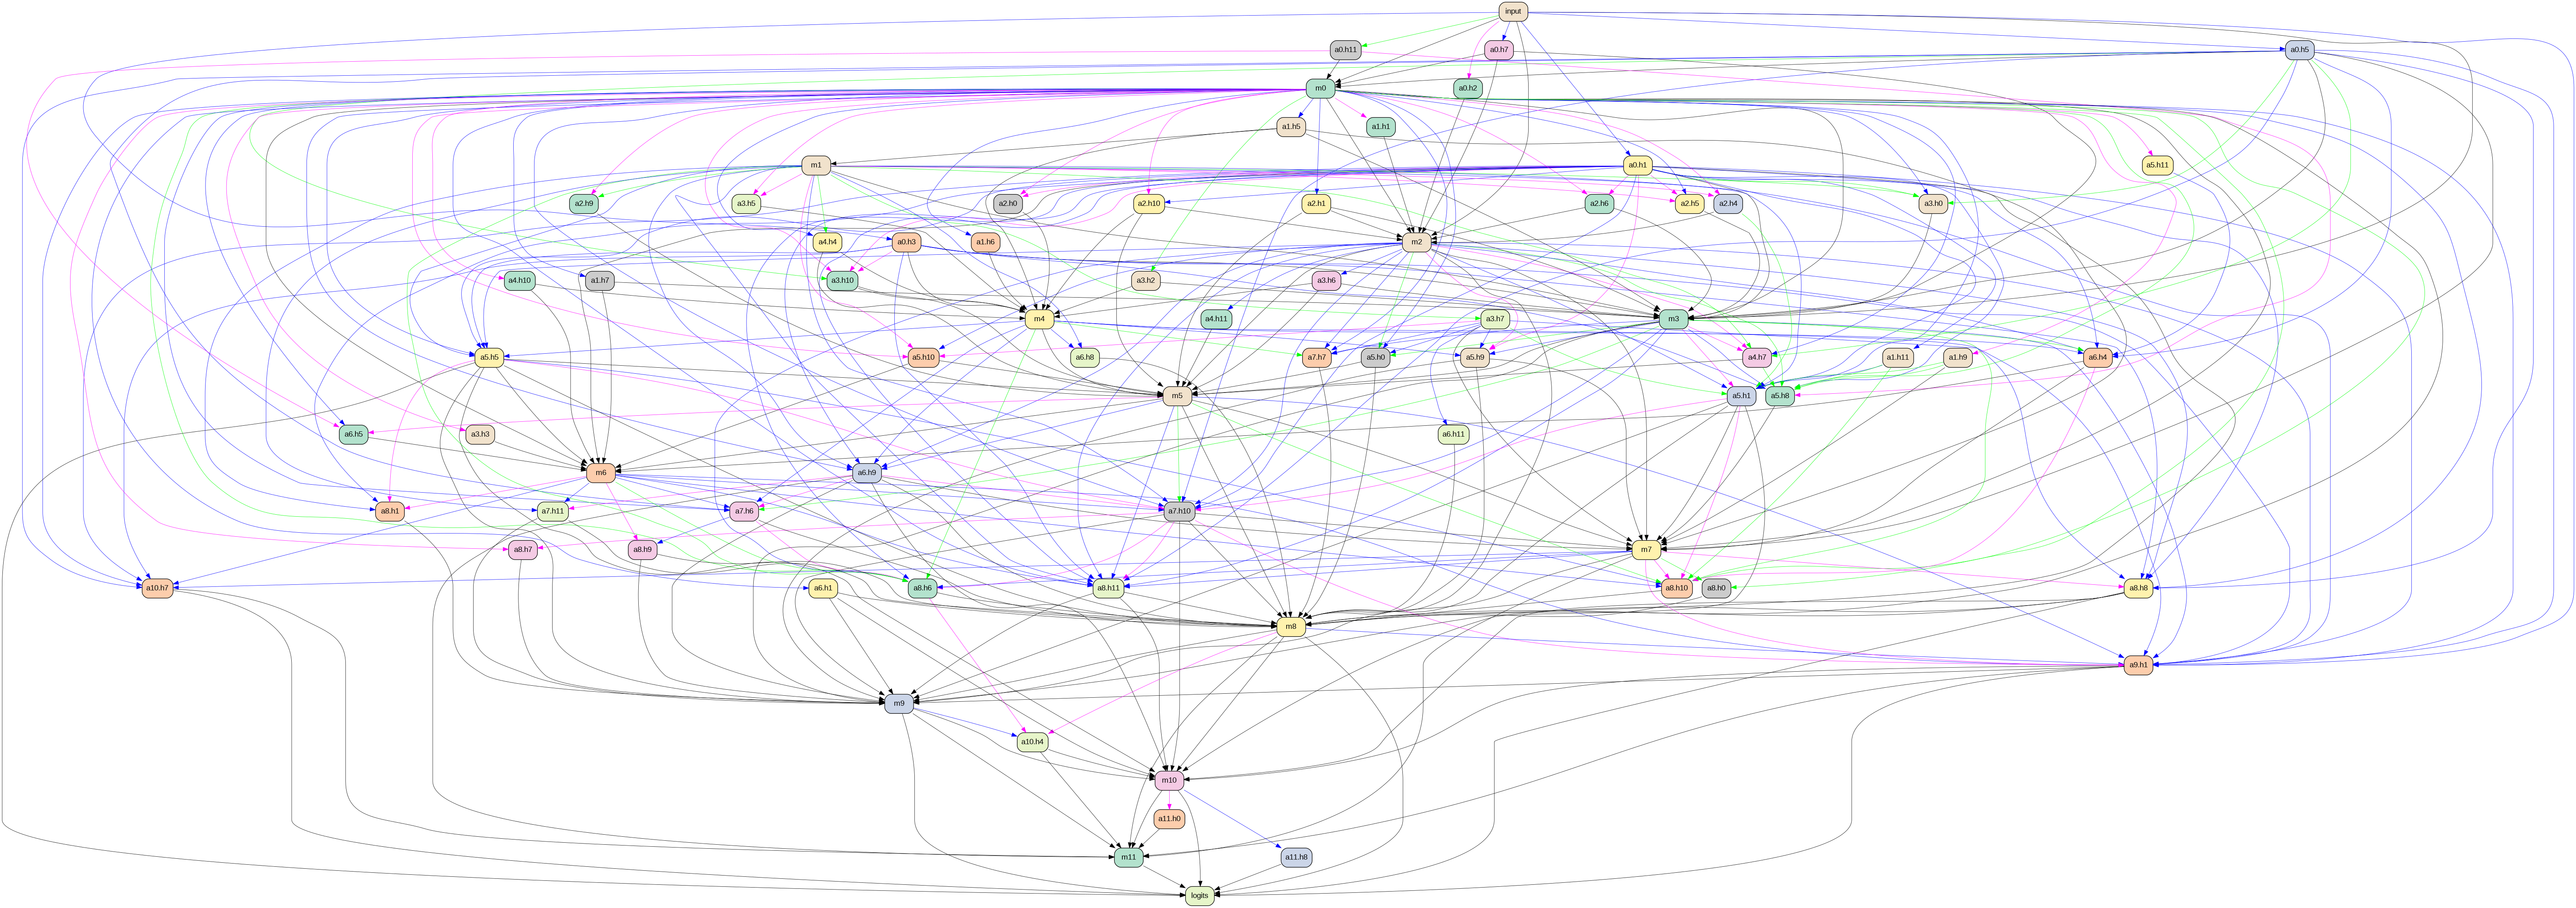

In [33]:
gz = g.to_graphviz()
gz.draw('graph.png', prog='dot')
Image(filename='graph.png')

In [34]:
g.to_json('graph.json')

### 3.5 Evaluating our Circuit

Finally, we can evaluate our circuit! How faithful is it to our model, anyway? It's easy to test using `evaluate_graph`, which ablates all edges not in the graph.

In [35]:
results = evaluate.evaluate_graph(model, g, dataset, metric).mean()
print(f"baseline performance: {baseline}. circuit performance: {results}")

100%|██████████| 125/125 [01:35<00:00,  1.31it/s]

baseline performance: 0.8158785104751587. circuit performance: 0.8178607225418091


### 3.5 Evaluating a Hand-Found Circuit
What if we already have a circuit in mind that we want to test? We can evaluate one of those in this framework too! For example, take the greater-than circuit that was found manually. Does it work? See below.

In [36]:
g_manual = Graph.from_model(model)
for edge in g_manual.edges.values():
    edge.in_graph=False

input_node = g_manual.nodes['input']
low_attn = ['a0.h3', 'a0.h5']
low_mlps = ['a0.h1', 'm0', 'm1', 'm2', 'm3']
mid_attn = ['a5.h1', 'a5.h5','a6.h1','a6.h9', 'a7.h10', 'a8.h8', 'a8.h11', 'a9.h1']
high_mlps = [f'm{i}' for i in range(8,12)]
logit_node = g_manual.nodes['logits']

for node in low_attn + low_mlps:
    if f'input->{node}' in g_manual.edges:
        g_manual.edges[f'input->{node}'].in_graph = True
    else:
        for letter in 'qkv':
            g_manual.edges[f'input->{node}<{letter}>'].in_graph = True

    for node2 in mid_attn:
        for letter in 'qkv':
            g_manual.edges[f'{node}->{node2}<{letter}>'].in_graph = True

for i, node in enumerate(low_mlps):
    for node2 in low_mlps[i+1:]:
        g_manual.edges[f'{node}->{node2}'].in_graph = True

for node in mid_attn:
    g_manual.edges[f'{node}->logits'].in_graph=True
    for node2 in high_mlps:
        edge_str = f'{node}->{node2}'
        if edge_str in g_manual.edges:
            g_manual.edges[edge_str].in_graph=True

for i, node in enumerate(high_mlps):
    g_manual.edges[f'{node}->logits'].in_graph=True
    for node2 in high_mlps[i+1:]:
        g_manual.edges[f'{node}->{node2}'].in_graph = True
g_manual.prune_dead_nodes(prune_childless=True, prune_parentless=True)
results = evaluate.evaluate_graph(model, g_manual, dataset, metric).mean()
print(f"baseline performance: {baseline}. circuit performance: {results}")

100%|██████████| 125/125 [00:45<00:00,  2.75it/s]

baseline performance: 0.8158785104751587. circuit performance: 0.7294778823852539


The performance is worse, but the circuit is much smaller! You can go back and test how well an automatically found circuit of equivalent size would be. You can also look at the manual circuit.

In [37]:
print(f"The auto-circuit has {g.count_included_edges()}, while the manual circuit has {g_manual.count_included_edges()}")

The auto-circuit has 377, while the manual circuit has 240


In [38]:
for edge in g_manual.edges.values():
    if edge.score is None:
        edge.score = 0
gz_manual = g_manual.to_graphviz()
gz_manual.draw('graph_manual.png', prog='dot')
Image(filename='graph_manual.png')

## 4 Play around with Circuits
Congrats on making it through this notebook! Now you can try playing with circuits on your own. You can try, for example:
- using a different number of edges in the circuit
- using a different model
- creating a different task

If you're interested, there's also another kind of attribution that can be activated by setting running `attribute.attribute(model, g, dataset, partial(metric, loss=True, mean=True), integrated_gradients=30)`. This doesn't work well on the greater-than task, but works very well on some attention-head-heavy tasks where EAP normally fails. This is EAP with [integrated gradients](https://arxiv.org/abs/1703.01365); see my upcoming paper for more details!

## 5. Bonus

Congratulations on finishing this notebook! Mechanistic interpretability is a large field, though, and we've only scratched the surface of it. Here are some interesting lines of work that you might want to look into when you're done with this.

- Circuits work:
    - in real language models:
        - [IOI](https://arxiv.org/abs/2211.00593)
        - [Greater-Than](https://arxiv.org/abs/2305.00586)
        - [Entity Tracking](https://openreview.net/forum?id=8sKcAWOf2D)
        - [Sentiment](https://arxiv.org/abs/2310.15154)
        - [QA in Chinchilla](https://arxiv.org/abs/2307.09458)
        - [Circuit Component Re-use](https://arxiv.org/abs/2310.08744)
    - in toy models:
        - [Grokking modular addition](https://openreview.net/forum?id=9XFSbDPmdW)
        - [Docstring circuit](https://www.lesswrong.com/posts/u6KXXmKFbXfWzoAXn/a-circuit-for-python-docstrings-in-a-4-layer-attention-only)
- Automated circuit finding work:
    - [Automated Circuit Discovery](https://arxiv.org/abs/2304.14997)
    - Edge Attribution Patching:
        - [original blog post](https://www.neelnanda.io/mechanistic-interpretability/attribution-patching)
        - [paper](https://arxiv.org/abs/2310.10348)
        - [AtP*, a follow-up](https://arxiv.org/abs/2403.00745)
        - EAP-IG (coming soon!)
- Studies of individual components:
    - [Successor Heads](https://openreview.net/pdf?id=kvcbV8KQsi)
    - [Copy Suppression](https://arxiv.org/abs/2310.04625)
- Mechanistic Interpretability Methods:
    - [Path Patching](https://arxiv.org/abs/2304.05969)
    - [Subspace Patching Illusions](https://arxiv.org/abs/2311.17030) and this [rebuttal](https://arxiv.org/abs/2401.12631)
    - [Best Practices in Activation Patching](https://openreview.net/forum?id=Hf17y6u9BC)
    - [Causal Scrubbing](https://www.alignmentforum.org/posts/JvZhhzycHu2Yd57RN/causal-scrubbing-a-method-for-rigorously-testing)
- Anthropic's work on mech. interp.:
    - [A Mathematical Framework for Circuits](https://www.anthropic.com/index/a-mathematical-framework-for-transformer-circuits), and a [recent update](https://www.anthropic.com/index/circuits-updates-may-2023)
    - [Induction Heads](https://www.anthropic.com/index/in-context-learning-and-induction-heads)
    - [Superposition](https://www.anthropic.com/index/toy-models-of-superposition) and [SoLU](https://www.anthropic.com/index/softmax-linear-units)
    - [Privileged Bases in the Residual Stream](https://www.anthropic.com/index/privileged-bases-in-the-transformer-residual-stream)

- Other cool (mostly) mechanistic work:
    - [ROME](https://arxiv.org/pdf/2202.05262.pdf) and this [follow-up](https://arxiv.org/pdf/2301.04213.pdf), plus more on fact retrieval: [paper 1](https://arxiv.org/abs/2304.14767) [paper 2](https://openreview.net/forum?id=P2gnDEHGu3) [paper 3](https://www.alignmentforum.org/posts/iGuwZTHWb6DFY3sKB/fact-finding-attempting-to-reverse-engineer-factual-recall)
    - [Interpreting a model trained to play Othello](https://arxiv.org/abs/2210.13382) and this [follow up](https://www.neelnanda.io/mechanistic-interpretability/othello).
    - The ["hydra effect"](https://arxiv.org/abs/2307.15771)
    - Chris Olah's [blog posts](https://distill.pub/2020/circuits/) on circuits in ConvNets

If you're looking for more notebooks or practice with TransformerLens, have a look at these:
- [Original Demo Notebook](https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Main_Demo.ipynb)
- [Intro to mechanistic interpretability (from ARENA)](https://arena3-chapter1-transformer-interp.streamlit.app/)